In [1]:
from proxbias.depmap.process import compute_monte_carlo_stats
from proxbias.depmap.load import get_depmap_data
from proxbias.utils.data_utils import get_cancer_gene_lists
from proxbias.metrics import genome_proximity_bias_score
from proxbias.depmap.constants import *

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import pickle
import ast
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
crispr_effect, _, cnv_data, mutation_data = get_depmap_data(rnai_release="")
oncogenes, tsgs = get_cancer_gene_lists(crispr_effect.index)

CRISPRGeneEffect.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsCNGene.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsSomaticMutations.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!


In [4]:
%%time
# Note - n_workers should likely be around half the number of CPUs
res = compute_monte_carlo_stats(
    genes_of_interest=["TP53"],
    dependency_data=crispr_effect,
    cnv_data=cnv_data,
    mutation_data=mutation_data,
    candidate_models=list(crispr_effect.columns),
    search_mode="lof",
    n_iterations=100,
    eval_function=genome_proximity_bias_score,
    eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
    n_workers=4,
    cnv_cutoffs=(1.75, 2.25)
)
res.head()

Stats for TP53 computed in 175.83291602134705 - diff is 0.04008458619999988, 200 wt and 444 lof
CPU times: user 278 ms, sys: 154 ms, total: 432 ms
Wall time: 2min 57s


,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt
TP53,"[0.67238148, 0.66245808, 0.6586740799999999, 0...",0.667355,"[0.63087722, 0.6287808799999999, 0.632288, 0.6...",0.627271,0.040085,lof,160,444,200


In [5]:
#write a function that performs a t-test for the bootstrap estimates
def perform_t_test(df: pd.DataFrame) -> pd.DataFrame:
    df = df.reset_index().rename(columns={'index': 'gene'})

    # Initialize t_stat and p_value columns in the original DataFrame
    df['t_stat'] = None
    df['p_value'] = None

    for index, row in df.iterrows():
        test_stats = row['test_stats']
        wt_stats = row['wt_stats']

        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(test_stats, wt_stats)
        
        # Assign t_stat and p_value to the respective columns in the DataFrame
        df.at[index, 't_stat'] = t_stat
        df.at[index, 'p_value'] = p_value
    
    return df
pd.options.display.float_format = '{:.10e}'.format
ttest=perform_t_test(res)
ttest

,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,t_stat,p_value
0,TP53,"[0.67238148, 0.66245808, 0.6586740799999999, 0...",6.6735532760e-01,"[0.63087722, 0.6287808799999999, 0.632288, 0.6...",6.2727074140e-01,4.0084586200e-02,lof,160,444,200,4.6508027813e+01,1.6043252872e-108


In [6]:
### write a function to scramble a given column's values
def scramble_column(df: pd.DataFrame, column_name: str = 'ModelID', seed: int = None) -> pd.DataFrame:
    scrambled_df = df.copy()
    
    # Check if the specified column is in the DataFrame
    if column_name in scrambled_df.columns:
        # Extract the specified column
        column_values = scrambled_df[column_name].tolist()
    else:
        # Extract the index if the column is not a regular column
        column_values = scrambled_df.index.tolist()
    
    # Shuffle the column values list with the specified seed
    if seed is not None:
        random.seed(seed)
    random.shuffle(column_values)
    
    # Assign the scrambled column values list back to the DataFrame
    if column_name in scrambled_df.columns:
        scrambled_df[column_name] = column_values
    else:
        scrambled_df.index = column_values
    
    return scrambled_df

### write a function to scramble column names
def scramble_column_names(df: pd.DataFrame, seed: int = None) -> pd.DataFrame:
    scrambled_df = df.copy()
    column_names = list(scrambled_df.columns)

    # Shuffle column names list with the specified seed
    if seed is not None:
        random.seed(seed)
    random.shuffle(column_names)

    # Assign scrambled column names back to the DataFrame
    scrambled_df.columns = column_names
    return scrambled_df


# Assuming crispr_effect is a DataFrame
scrambled_cnv_data = scramble_column_names(cnv_data, seed=60)
scrambled_cnv_data


,ACH-000349,ACH-002151,ACH-000137,ACH-002045,ACH-001125,ACH-001704,ACH-000443,ACH-001611,ACH-002311,ACH-002271,...,ACH-001524,ACH-002163,ACH-001548,ACH-002288,ACH-000756,ACH-001691,ACH-002660,ACH-002251,ACH-002212,ACH-001032
FAM87B,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
LINC01128,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
AL669831.7,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
FAM41C,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
LINC02593,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPS4Y2,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.0005114246e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,1.8121702185e-07
PRORY,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.1190857660e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,5.7013514982e-10
TTTY13,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.1190857660e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,5.7013514982e-10
TTTY5,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.1190857660e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,5.7013514982e-10


In [7]:
#Test compute_monte_carlo_stats on just one scrambled version of the cnv data
scrambled_res = compute_monte_carlo_stats(
    genes_of_interest=["TP53"],
    dependency_data=crispr_effect,
    cnv_data=scrambled_cnv_data,
    mutation_data=mutation_data,
    candidate_models=list(crispr_effect.columns),
    search_mode="lof",
    n_iterations=100,
    eval_function=genome_proximity_bias_score,
    eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
    n_workers=4
)

#add on a t-test
null_ttest=perform_t_test(scrambled_res)
null_ttest

Stats for TP53 computed in 169.59125781059265 - diff is 0.030261239999999967, 203 wt and 343 lof


,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,t_stat,p_value
0,TP53,"[0.6804448, 0.66608688, 0.6760476799999999, 0....",6.7706427600e-01,"[0.6486923400000001, 0.6459512, 0.64140104, 0....",6.4680303600e-01,3.0261240000e-02,lof,162,343,203,3.4832795561e+01,2.1996272262e-86


In [8]:
#write a function that creates a permuted null across many shufflings of the data
def permute_null_t_test(mutation_data,
                        crispr_effect,
                        cnv_data,
                        n_shuffles,
                        n_min_cell_lines=25,
                        genes=["TP53"],
                        candidate_models=list(crispr_effect.columns),
                        eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
                        **kwargs):
    permuted_null_t_test = pd.DataFrame()

    #put observed results in dataframe
    observed_data = compute_monte_carlo_stats(
            genes_of_interest=genes,
            dependency_data=crispr_effect,
            cnv_data=cnv_data,
            mutation_data=mutation_data,
            n_min_cell_lines=n_min_cell_lines,
            candidate_models=candidate_models,
            eval_function=genome_proximity_bias_score,
            eval_kwargs=eval_kwargs,
            n_workers=4,
            **kwargs
        )
    
    observed_data['seed'] = 0
    observed_data['result_type'] = "observed"
    observed_data = perform_t_test(observed_data)


    random_seeds = [random.randint(1, 1000) for _ in range(n_shuffles)]

    for seed in random_seeds:
        scrambled_cnv_data = scramble_column_names(cnv_data, seed=seed)  # Use a single seed for scrambling
        
        # Perform t-test for each gene
        scrambled_res_gene = compute_monte_carlo_stats(
            genes_of_interest=genes,
            dependency_data=crispr_effect,
            cnv_data=scrambled_cnv_data,
            mutation_data=mutation_data,
            n_min_cell_lines=n_min_cell_lines,
            candidate_models=candidate_models,
            eval_function=genome_proximity_bias_score,
            eval_kwargs=eval_kwargs,
            n_workers=4,
            **kwargs
        )
        
        # Add a column for the seed
        scrambled_res_gene['seed'] = seed
        scrambled_res_gene['result_type'] = "empirical_null"
        scrambled_res_gene = perform_t_test(scrambled_res_gene)
        
        # Concatenate the result with the existing DataFrame
        permuted_null_t_test = pd.concat([permuted_null_t_test, scrambled_res_gene], ignore_index=True)
    
    permuted_null_t_test = pd.concat([observed_data, permuted_null_t_test], ignore_index=True).sort_values(["gene", "seed"])
    return permuted_null_t_test

permuted_null = permute_null_t_test(mutation_data,
                                    crispr_effect,
                                    cnv_data,
                                    n_shuffles=2,
                                    n_iterations=5)

permuted_null

Stats for TP53 computed in 11.124104976654053 - diff is 0.024002160000000217, 247 wt and 344 lof
Stats for TP53 computed in 10.12348198890686 - diff is 0.04142774399999993, 212 wt and 340 lof
Stats for TP53 computed in 10.150838613510132 - diff is 0.013345607999999842, 207 wt and 334 lof


,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,seed,result_type,t_stat,p_value
0,TP53,"[0.67920954, 0.6675941400000001, 0.66288408, 0...",6.7089631600e-01,"[0.6480423999999999, 0.6497969, 0.64489834, 0....",6.4689415600e-01,2.4002160000e-02,lof,197,344,247,0,observed,7.0818078592e+00,1.0384359753e-04
1,TP53,"[0.68365492, 0.68168412, 0.6755391199999999, 0...",6.8154856800e-01,"[0.6393698400000001, 0.6372060199999999, 0.644...",6.4012082400e-01,4.1427744000e-02,lof,169,340,212,162,empirical_null,1.5950897657e+01,2.3906835367e-07
2,TP53,"[0.65642648, 0.66080586, 0.6575931800000001, 0...",6.5558866400e-01,"[0.6334105600000001, 0.6443862, 0.64300366, 0....",6.4224305600e-01,1.3345608000e-02,lof,165,334,207,920,empirical_null,3.6040093044e+00,6.9417687317e-03


In [9]:
#subset to cell lines with less than 1% CNVs
cnv_data_trans = 2 * (np.power(2, cnv_data) - 1)
cnv_calls = (cnv_data_trans < 1.75) | (cnv_data_trans > 2.25)
cnv_call_pers = cnv_calls.mean(axis=0).sort_values(ascending=False)
least_cnv_cl_01 = list(set(cnv_call_pers[cnv_call_pers < 0.01].index)) #there are only 21 of these cell lines, so these werent used for the driver analysis

#all columns
all_columns = set(cnv_data.columns).intersection(set(crispr_effect.columns)).intersection(set(mutation_data['ModelID']))

# Get p53 loss-of-function (lof) cell lines
tp53_loss_cell_lines = set(cnv_data_trans.T[["TP53"]].query("TP53 <= 1.5").index).intersection(all_columns)

# Get p53 wild-type (wt) cell lines
tp53_wt = all_columns - tp53_loss_cell_lines

# Convert sets to lists
tp53_copy_loss = list(tp53_loss_cell_lines)
tp53_wt = list(tp53_wt)

# Subset the mutation dataframes by P53 status
p53_lof_mutation_data = mutation_data[mutation_data['ModelID'].isin(tp53_copy_loss)]
p53_lof_crispr_effect = crispr_effect[tp53_copy_loss]

p53_wt_mutation_data = mutation_data[mutation_data['ModelID'].isin(tp53_wt)]
p53_wt_crispr_effect = crispr_effect[tp53_wt]

In [24]:
#write a function that either reads null from disc or creates it
def load_or_create_permuted_null(file_name, mutation_data, crispr_effect, cnv_data, search_mode):
    if os.path.exists(file_name):
        return pd.read_csv(file_name, sep="\t")
    else:
        permuted_null = permute_null_t_test(
            mutation_data,
            crispr_effect,
            cnv_data,
            n_shuffles=50,  # number of shufflings to do for empirical null generation (20-50 probably plenty)
            genes=["CDKN2A", "CDKN2B", "CDKN2C", "BTG2", "MDM4", "MDM2"],
            n_iterations=128,  # number of bootstraps (default is 100)
            search_mode=search_mode,
            n_min_cell_lines=25,
            fixed_cell_line_sampling=True,
            candidate_models=list(crispr_effect.columns),
            eval_kwargs={"n_samples": 20, "n_trials": 200, "return_samples": False}
        )
        permuted_null.to_csv(file_name, sep="\t")
        return permuted_null

In [25]:
p53_wt_permuted_null_LOF = load_or_create_permuted_null(
    "p53_wt_permuted_null_LOF_genes.txt",
    p53_wt_mutation_data,
    p53_lof_crispr_effect,
    cnv_data,
    search_mode="lof"
)

In [ ]:
p53_wt_permuted_null_AMP = load_or_create_permuted_null(
    "p53_wt_permuted_null_AMP_genes.txt",
    p53_wt_mutation_data,
    p53_lof_crispr_effect,
    cnv_data,
    search_mode="amp"
)

In [ ]:
p53_lof_permuted_null_LOF = load_or_create_permuted_null(
    "p53_lof_permuted_null_LOF_genes.txt",
    p53_lof_mutation_data,
    p53_lof_crispr_effect,
    cnv_data,
    search_mode="lof"
)

In [ ]:
p53_lof_permuted_null_AMP = load_or_create_permuted_null(
    "p53_lof_permuted_null_AMP_genes.txt",
    p53_lof_mutation_data,
    p53_lof_crispr_effect,
    cnv_data,
    search_mode="amp"
)

### Compute Empirical Null for LoF Drivers on P53 LoF

In [26]:
p53_wt_permuted_null_LOF

,Unnamed: 0,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,seed,result_type,t_stat,p_value
0,34,BTG2,"[0.5810875, 0.5729625, 0.5844, 0.5787625, 0.55...",5.7471708984e-01,"[0.5654, 0.579375, 0.5550375, 0.5484, 0.576787...",5.7047480469e-01,4.2422851563e-03,lof,20,25,209,775,empirical_null,3.1757862216e+00,1.6789118867e-03
1,0,CDKN2A,"[0.5957125, 0.576875, 0.58545, 0.5838875, 0.57...",5.7583593750e-01,"[0.575625, 0.5657875, 0.5755250000000001, 0.54...",5.5949199219e-01,1.6343945312e-02,lof,20,221,88,0,observed,8.8062851002e+00,2.0569946535e-16
2,17,CDKN2A,"[0.57355, 0.5663375, 0.562025, 0.5569250000000...",5.7899345703e-01,"[0.55985, 0.5672125, 0.5618124999999999, 0.571...",5.6131845703e-01,1.7675000000e-02,lof,20,196,127,23,empirical_null,9.5784350666e+00,9.4245024844e-19
3,99,CDKN2A,"[0.5794250000000001, 0.55075, 0.550175, 0.5726...",5.6581318359e-01,"[0.5964, 0.5776, 0.59015, 0.5747, 0.5977625000...",5.8047451172e-01,-1.4661328125e-02,lof,20,182,141,38,empirical_null,-7.9909700315e+00,4.6967086950e-14
4,51,CDKN2A,"[0.5619625, 0.559875, 0.53945, 0.562875, 0.561...",5.6873613281e-01,"[0.5781499999999999, 0.5783125, 0.593875, 0.57...",5.7392812500e-01,-5.1919921875e-03,lof,20,180,135,49,empirical_null,-2.8299806546e+00,5.0271225448e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,98,CDKN2C,"[0.5752375, 0.567075, 0.5512999999999999, 0.57...",5.6716025391e-01,"[0.5813875, 0.5755625, 0.5677375, 0.5854874999...",5.7197216797e-01,-4.8119140625e-03,lof,20,52,235,956,empirical_null,-2.9228710832e+00,3.7808755263e-03
152,131,CDKN2C,"[0.5676000000000001, 0.5573875, 0.5631375, 0.5...",5.5952519531e-01,"[0.5789, 0.5812, 0.5561, 0.5425375, 0.58292499...",5.7149531250e-01,-1.1970117187e-02,lof,20,55,235,971,empirical_null,-7.1638507593e+00,8.4747667574e-12
153,80,CDKN2C,"[0.60075, 0.5855499999999999, 0.55553749999999...",5.9449062500e-01,"[0.5718125, 0.5672625, 0.5360375, 0.5519875, 0...",5.6923457031e-01,2.5256054688e-02,lof,20,45,237,975,empirical_null,1.4919250629e+01,1.4212477795e-36
154,2,MDM2,"[0.5748125000000001, 0.5730875000000001, 0.577...",5.7216347656e-01,"[0.546075, 0.5763875, 0.5863875000000001, 0.55...",5.6793554688e-01,4.2279296875e-03,lof,20,31,239,0,observed,2.5130507270e+00,1.2589163265e-02


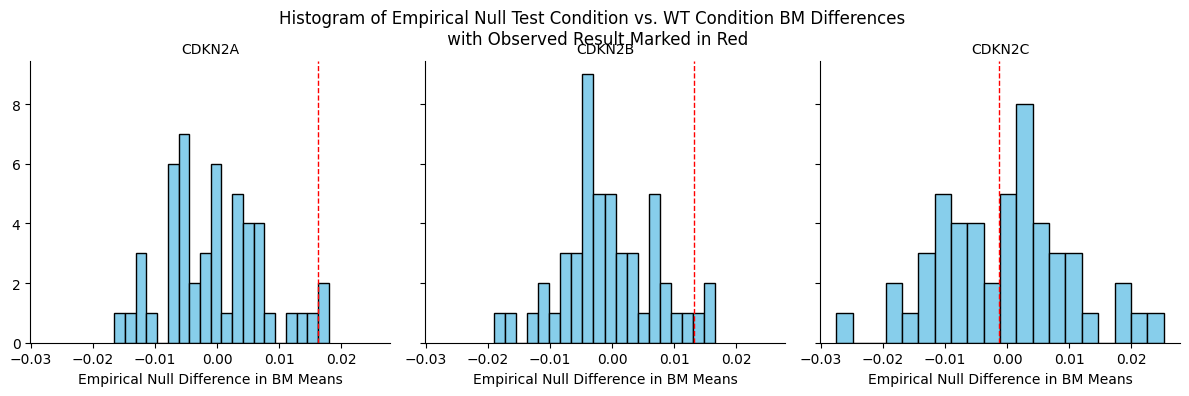

In [28]:
def plot_empirical_null_histogram(df, gene_column='gene'):
    """
    Plot histograms of 'empirical_null' diff values faceted by gene,
    with observed values marked by vertical red lines if they exist.

    Parameters:
    - df: pandas DataFrame containing the data
    - gene_column: name of the column to use for grouping (default: 'gene')

    Returns:
    - None (displays the plot)
    """
    # Filter data for "empirical_null" result_type
    df_empirical_null = df[df['result_type'] == 'empirical_null']

    # Find genes with "observed" values
    genes_with_observed = df[df['result_type'] == 'observed'][gene_column].unique()

    # Filter the empirical null data to only include genes with observed values
    df_empirical_null = df_empirical_null[df_empirical_null[gene_column].isin(genes_with_observed)]

    # FacetGrid with seaborn
    g = sns.FacetGrid(df_empirical_null, col=gene_column, col_wrap=3, height=4)

    # Plot histogram for each gene
    g.map(plt.hist, 'diff', bins=20, color='skyblue', edgecolor='black')

    # Add a vertical red line for the "observed" value in each facet
    for ax, gene in zip(g.axes.flat, df_empirical_null[gene_column].unique()):
        observed_diff = df[(df[gene_column] == gene) & (df['result_type'] == 'observed')]['diff'].values[0]
        ax.axvline(x=observed_diff, color='red', linestyle='--', linewidth=1)
        ax.set_xlabel('Empirical Null Difference in BM Means')

    # Adjust layout and display plot
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Histogram of Empirical Null Test Condition vs. WT Condition BM Differences \n with Observed Result Marked in Red')
    plt.show()

# Example usage:
# Assuming df is your pandas DataFrame with the provided data
plot_empirical_null_histogram(p53_wt_permuted_null_LOF, gene_column='gene')
